---------------

**If any part of this notebook is used in your research, please cite with the reference found in** **[README.md](https://github.com/pysal/spaghetti#bibtex-citation).**


----------------

## Generating regular lattices and visualizing shortest paths
### Creating data for testing and demonstrating routes

**Author: James D. Gaboardi** **<jgaboardi@gmail.com>**

**This notebook is a walk-through for:**

1. Instantiating a simple network through a generated regular lattice
2. Generating shortest path geometric objects
3. Visualizing shortest paths

In [1]:
%load_ext watermark
%watermark

2020-01-24T19:49:38-05:00

CPython 3.7.3
IPython 7.10.2

compiler   : Clang 9.0.0 (tags/RELEASE_900/final)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


**In addtion to the base** **[spaghetti requirements](https://github.com/pysal/spaghetti/blob/master/requirements.txt)** **(and their dependecies), this notebook requires installations of:**

* [geopandas](http://geopandas.org)
    * `$ conda install -c conda-forge geopandas`
* [matplotlib](https://matplotlib.org)
    * `$ conda install matplotlib`
    
-----------------------

In [2]:
import spaghetti
import matplotlib
import matplotlib.pyplot as plt
import libpysal
from libpysal.cg import Point
try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats("retina")
except ImportError:
    pass
%matplotlib inline
%watermark -w
%watermark -iv

watermark 2.0.2
libpysal   4.2.0
matplotlib 3.1.2
spaghetti  1.4.0



-----------------------------
### 1. Demonstration with a synthetic network
#### 1.1 Instantiate a network from a 4x4 regular lattice

In [3]:
lattice = spaghetti.regular_lattice(4)
ntw = spaghetti.Network(in_data=lattice)

#### 1.2. Extract network elements and visualize them

In [4]:
vertices, arcs = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)

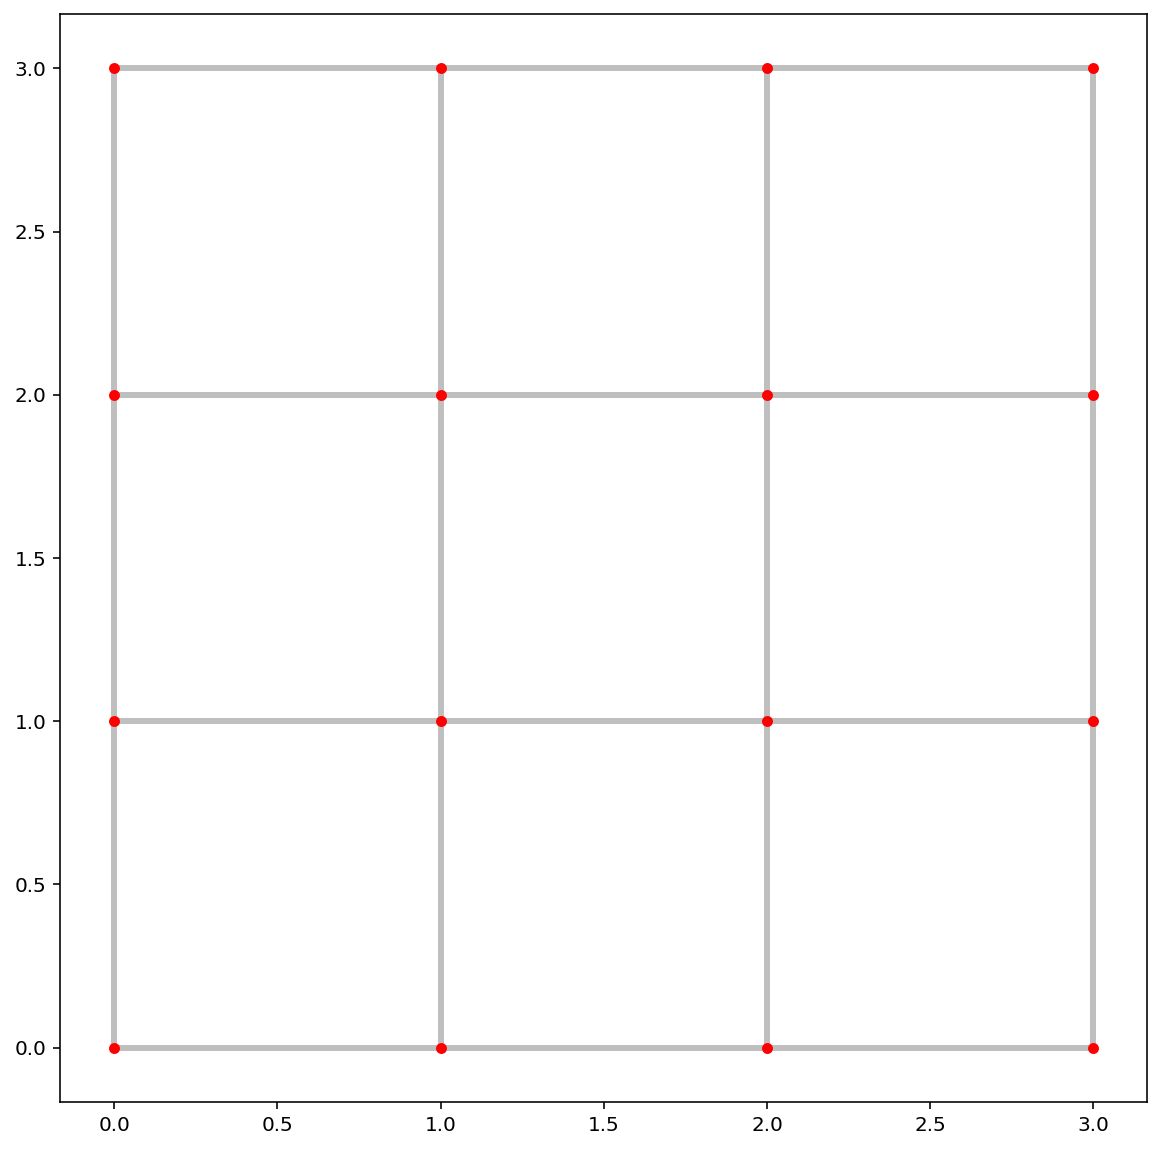

In [5]:
base = arcs.plot(linewidth=3, alpha=0.25, color="k", zorder=0, figsize=(10, 10))
vertices.plot(ax=base, markersize=20, color="red", zorder=1);

#### 1.3. Instantiate several synthetic observations and snap them to the network

In [6]:
synth_obs = [Point([0.2, 1.3]), Point([0.2, 1.7]), Point([2.8, 1.5])]
ntw.snapobservations(synth_obs, "synth_obs")

#### 1.4. Extract point patterns and visualize plot
##### Note the labeling for network elements and observations

In [7]:
# true locations of synthetic observations
pp_obs = spaghetti.element_as_gdf(ntw, pp_name="synth_obs")
# snapped locations of synthetic observations
pp_obs_snapped = spaghetti.element_as_gdf(ntw, pp_name="synth_obs", snapped=True)

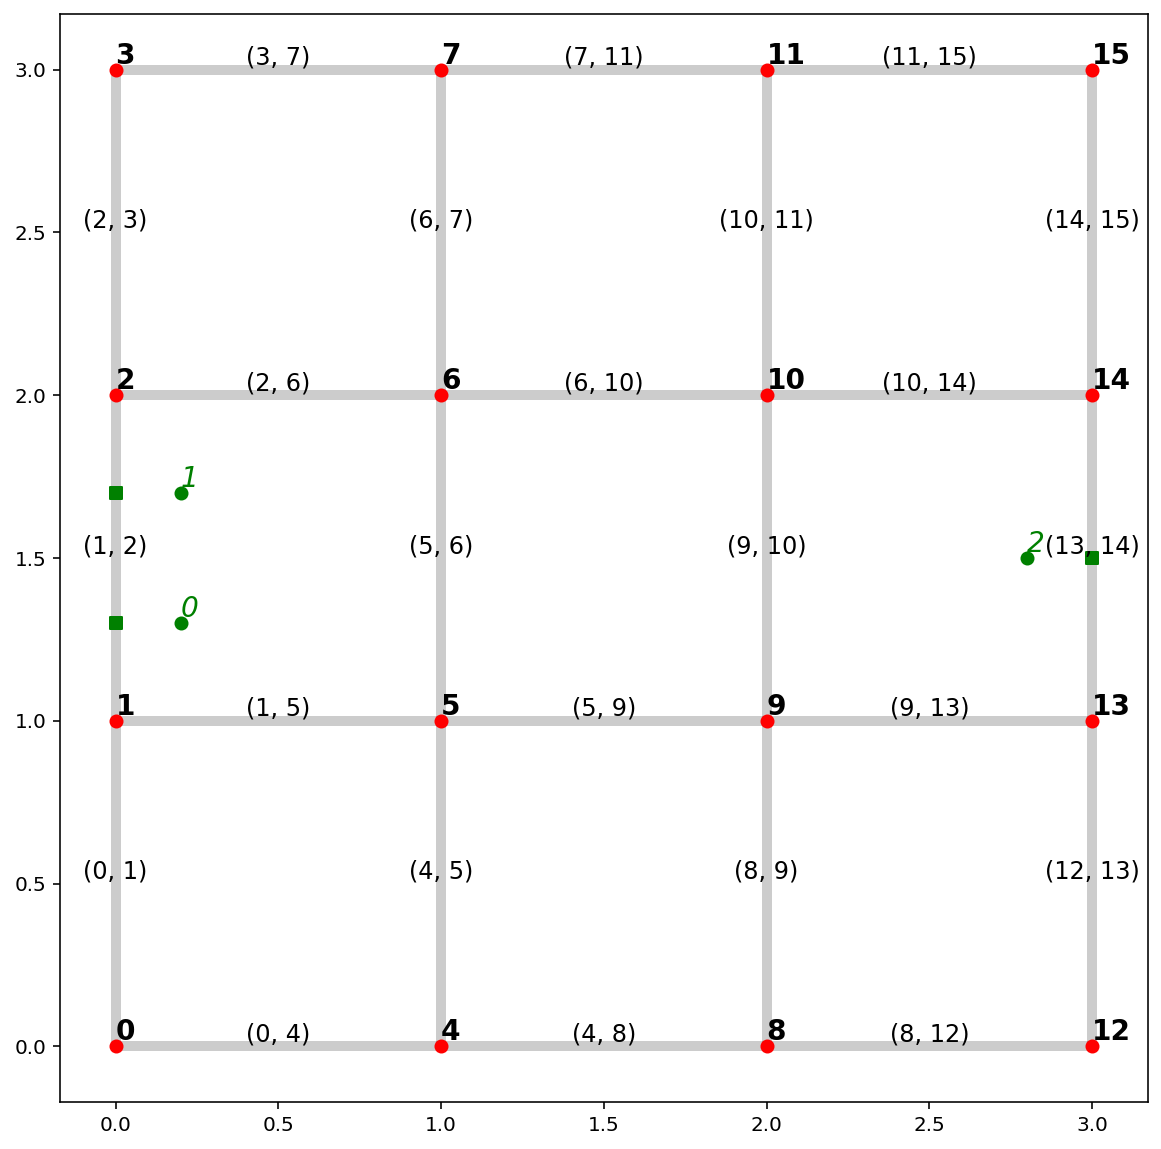

In [8]:
base = arcs.plot(alpha=0.2, linewidth=5, color="k", figsize=(10, 10), zorder=0)
vertices.plot(ax=base, color="r", zorder=1)
pp_obs.plot(ax=base, color="g", zorder=2)
pp_obs_snapped.plot(ax=base, color="g", marker="s", zorder=2)
# arc labels
arcs.apply(
    lambda x: base.annotate(
        s=x.id, xy=x.geometry.centroid.coords[0], size=12, ha="center", va="bottom"
    ),
    axis=1,
)
# vertex labels
vertices.apply(
    lambda x: base.annotate(
        s=x.id, xy=x.geometry.coords[0], weight="bold", size=14, ha="left", va="bottom"
    ),
    axis=1,
)
# synthetic observation labels
pp_obs.apply(
    lambda x: base.annotate(
        s=x.id,
        xy=x.geometry.coords[0],
        style="oblique",
        color="g",
        size=14,
        ha="left",
        va="bottom",
    ),
    axis=1,
);

#### 1.5. Generate observation shortest path trees

In [9]:
d2d_dist, tree = ntw.allneighbordistances("synth_obs", gen_tree=True)
d2d_dist

array([[nan, 0.4, 3.8],
       [0.4, nan, 3.8],
       [3.8, 3.8, nan]])

##### Note that a tag of ``(-0.1, -0.1)`` labels the points as being snapped to the same network arc

In [10]:
tree

{(0, 1): (-0.1, -0.1), (0, 2): (1, 13), (1, 2): (2, 14)}

#### 1.6. Generate shortest paths as ``libpysal.cg.Chain`` objects

In [11]:
paths = ntw.shortest_paths(tree, "synth_obs")
paths

{(0, 1): [(0.0, 1.3), (0.0, 1.7)],
 (0, 2): [(0.0, 1.3),
  (0.0, 1.0),
  (1.0, 1.0),
  (2.0, 1.0),
  (3.0, 1.0),
  (3.0, 1.5)],
 (1, 2): [(0.0, 1.7),
  (0.0, 2.0),
  (1.0, 2.0),
  (2.0, 2.0),
  (3.0, 2.0),
  (3.0, 1.5)]}

#### 1.7. Extract the shortest paths within ``geopandas.GeoDataFrame`` and plot

In [12]:
paths_gdf = spaghetti.element_as_gdf(ntw, routes=paths)
paths_gdf

,id,geometry
0,"(0, 1)","LINESTRING (0 1.3, 0 1.7)"
1,"(0, 2)","LINESTRING (0 1.3, 0 1, 1 1, 2 1, 3 1, 3 1.5)"
2,"(1, 2)","LINESTRING (0 1.7, 0 2, 1 2, 2 2, 3 2, 3 1.5)"


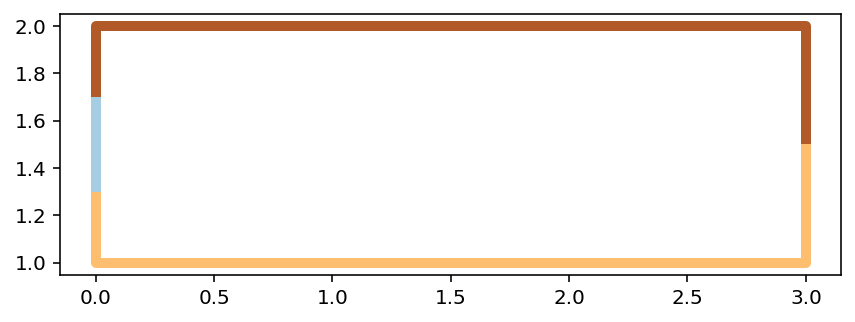

In [13]:
paths_gdf.plot(figsize=(7, 7), column=paths_gdf.index.name, cmap="Paired", linewidth=5);

#### 1.8. Plot the routes within the context of the network

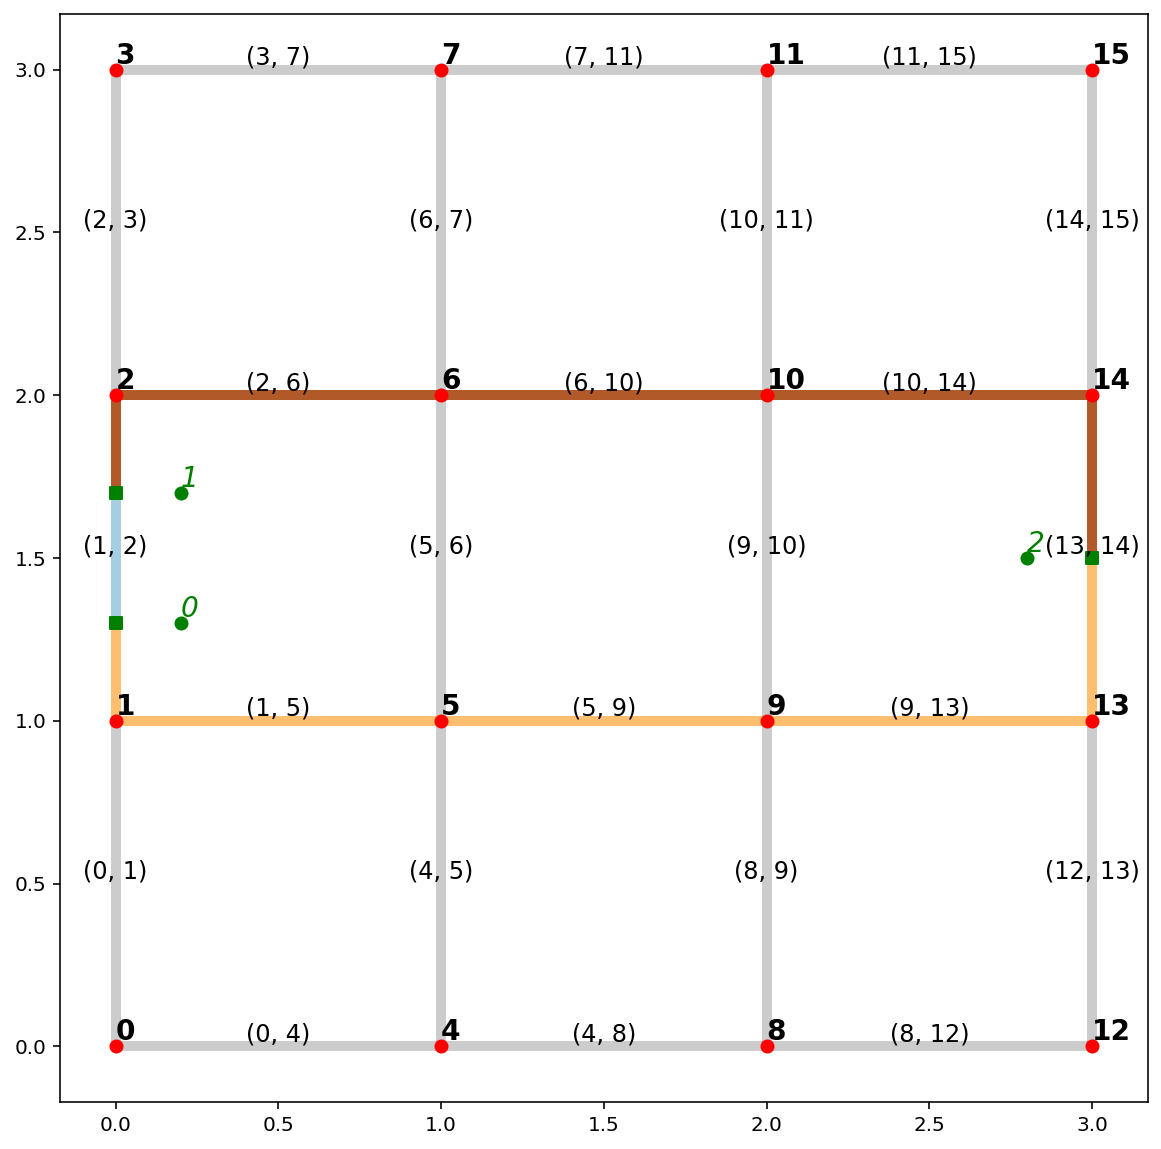

In [14]:
base = arcs.plot(alpha=0.2, linewidth=5, color="k", figsize=(10, 10), zorder=0)
paths_gdf.plot(ax=base, column="id", cmap="Paired", linewidth=5, zorder=1)
vertices.plot(ax=base, color="r", zorder=2)
pp_obs.plot(ax=base, color="g", zorder=3)
pp_obs_snapped.plot(ax=base, color="g", marker="s", zorder=2)
# arc labels
arcs.apply(
    lambda x: base.annotate(
        s=x.id, xy=x.geometry.centroid.coords[0], size=12, ha="center", va="bottom"
    ),
    axis=1,
)
# vertex labels
vertices.apply(
    lambda x: base.annotate(
        s=x.id, xy=x.geometry.coords[0], weight="bold", size=14, ha="left", va="bottom"
    ),
    axis=1,
)
# synthetic observation labels
pp_obs.apply(
    lambda x: base.annotate(
        s=x.id,
        xy=x.geometry.coords[0],
        style="oblique",
        color="g",
        size=14,
        ha="left",
        va="bottom",
    ),
    axis=1,
);

-----------------------------------
### 2. Demostration with emprical datasets
#### 2.1 Instantiate an emprical network, extract elements, and visualize

In [15]:
ntw = spaghetti.Network(in_data=libpysal.examples.get_path("streets.shp"))
vertices, arcs = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)

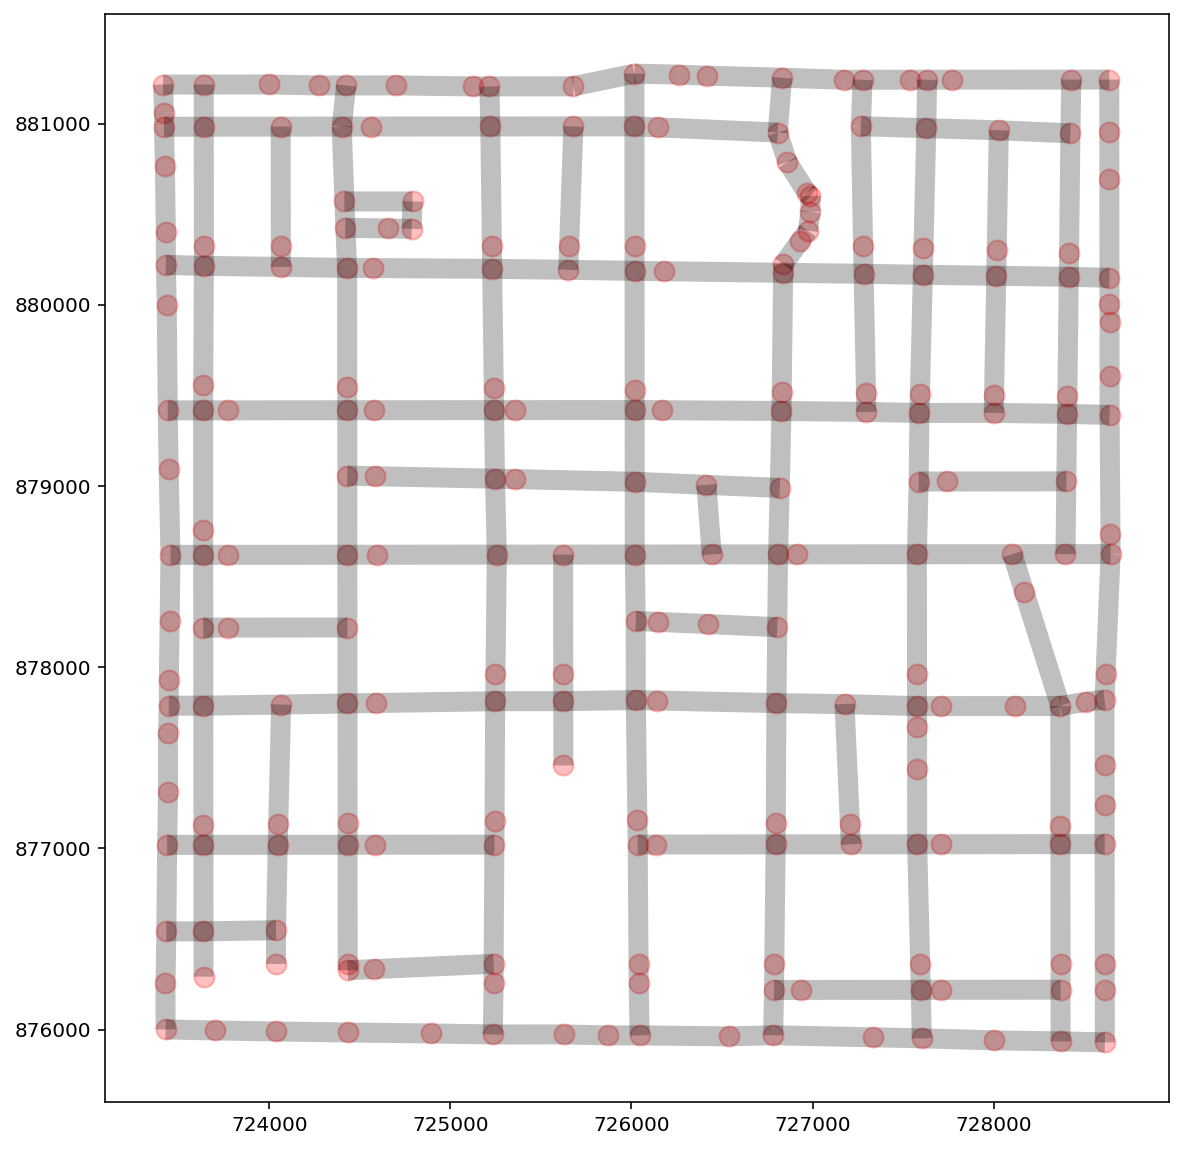

In [16]:
base = arcs.plot(linewidth=10, alpha=0.25, color="k", figsize=(10, 10))
vertices.plot(ax=base, markersize=100, alpha=0.25, color="red");

#### 2.2 Snap emprical observations and extract the point patterns as ``geopandas.GeoDataFrames``

In [17]:
ntw.snapobservations(libpysal.examples.get_path("schools.shp"), "schools")
pp_obs = spaghetti.element_as_gdf(ntw, pp_name="schools")
pp_obs_snapped = spaghetti.element_as_gdf(ntw, pp_name="schools", snapped=True)

#### 2.3 Plot empirical data

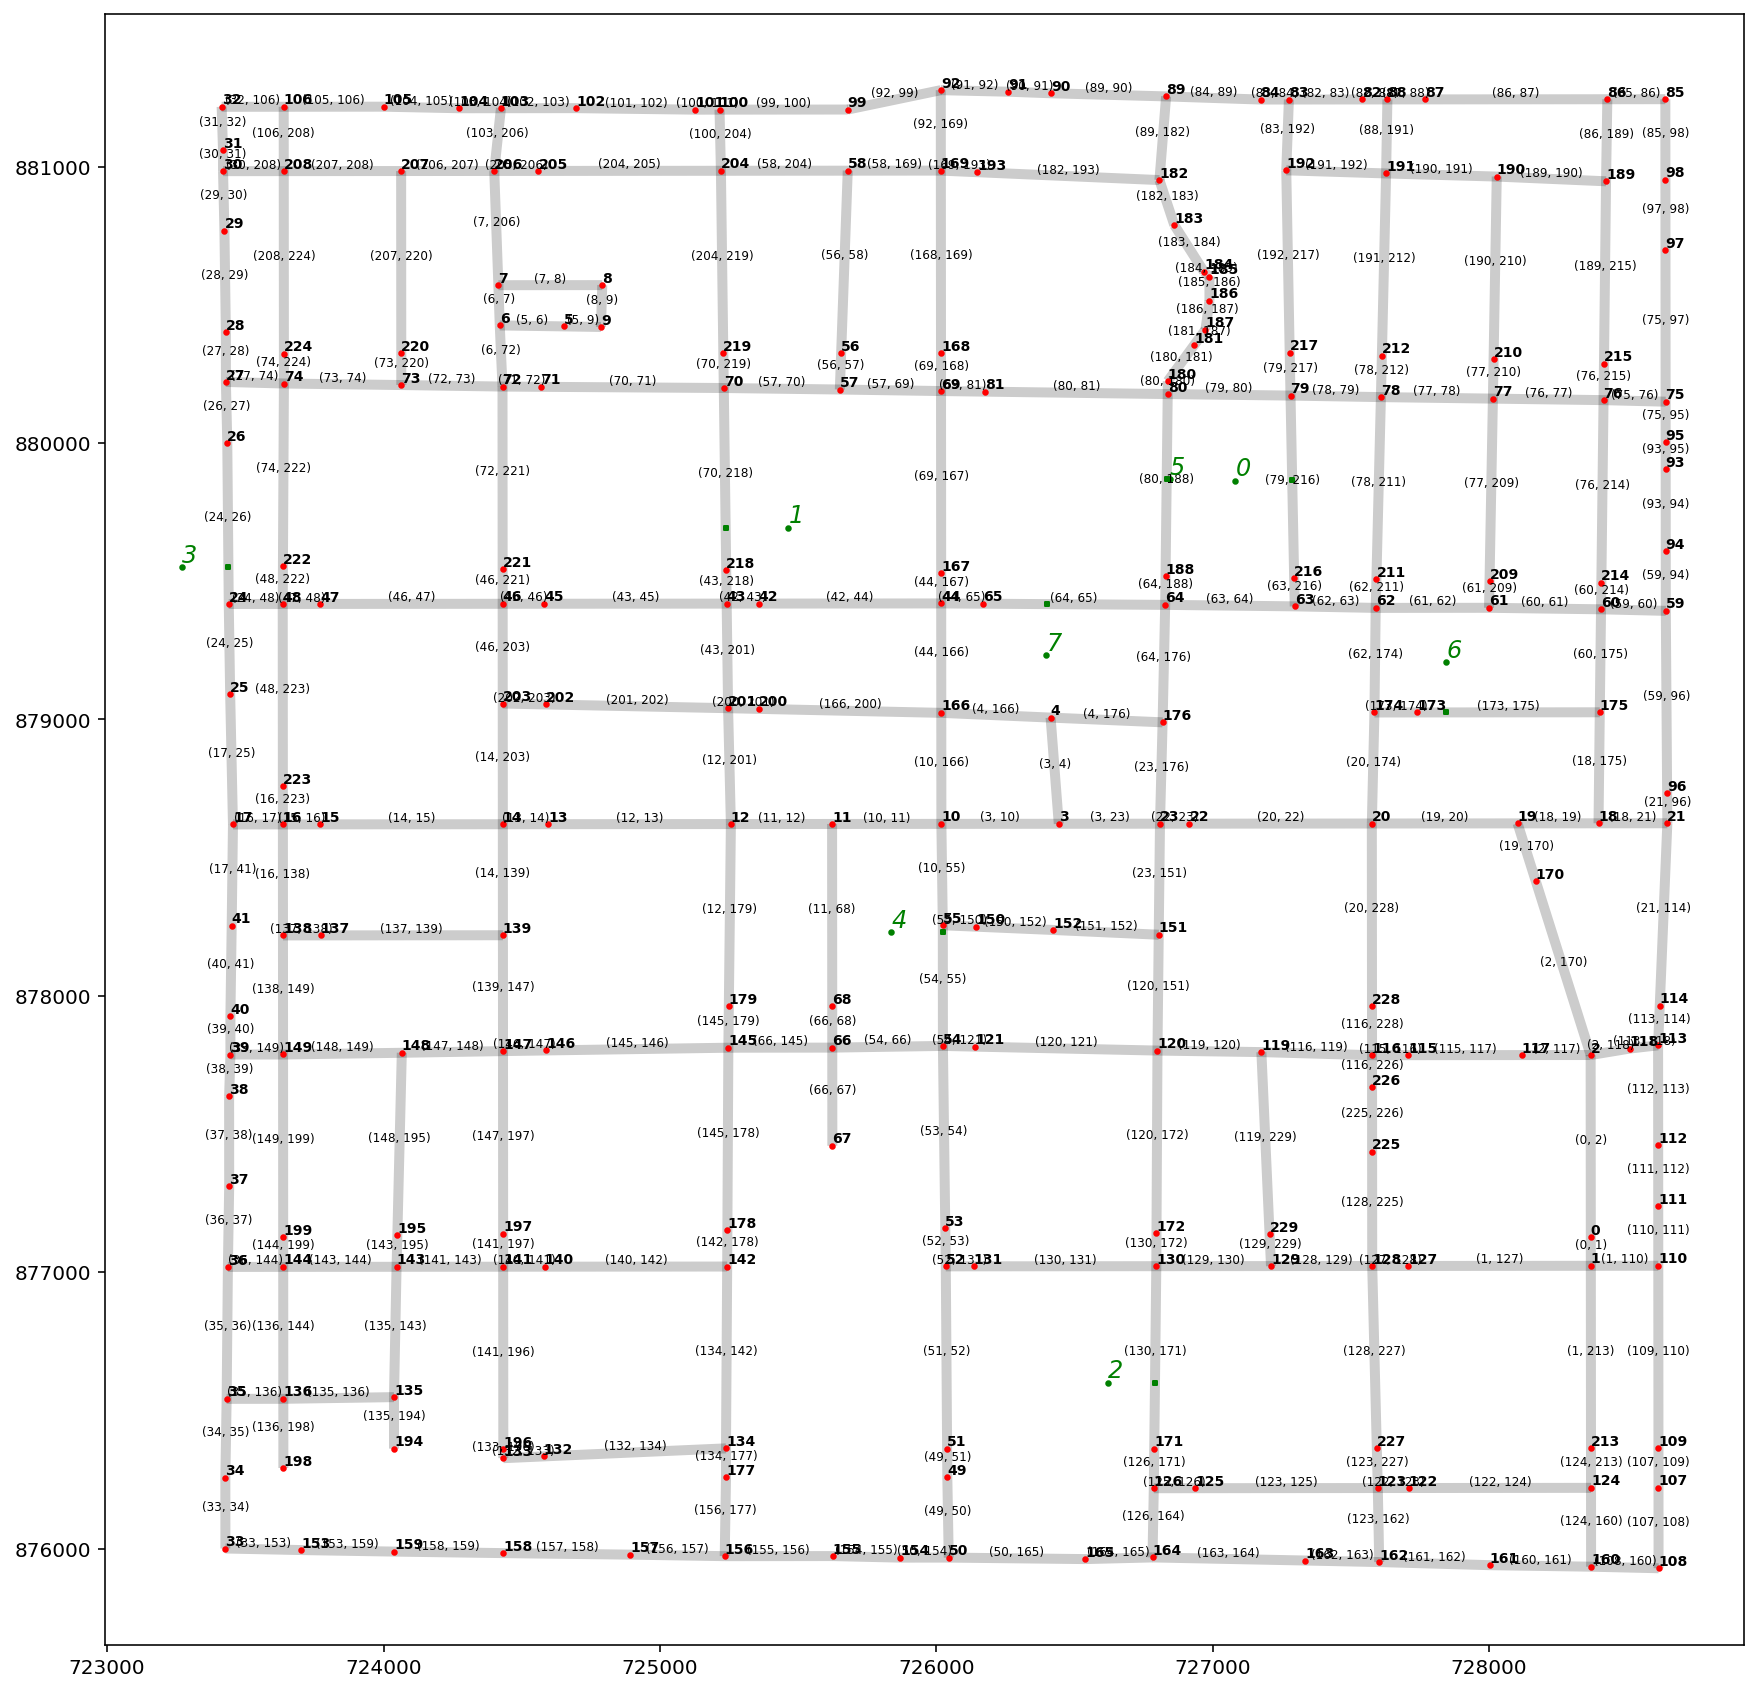

In [18]:
base = arcs.plot(alpha=0.2, linewidth=5, color="k", figsize=(15, 15), zorder=0)
vertices.plot(ax=base, markersize=5, color="r", zorder=1)
pp_obs.plot(ax=base, markersize=5, color="g", zorder=2)
pp_obs_snapped.plot(ax=base, markersize=5, marker="s", color="g", zorder=2)
# arc labels
arcs.apply(
    lambda x: base.annotate(
        s=x.id, xy=x.geometry.centroid.coords[0], size=6, ha="center", va="bottom"
    ),
    axis=1,
)
# vertex labels
vertices.apply(
    lambda x: base.annotate(
        s=x.id, xy=x.geometry.coords[0], weight="bold", size=7, ha="left", va="bottom"
    ),
    axis=1,
)
# school labels
pp_obs.apply(
    lambda x: base.annotate(
        s=x.id,
        xy=x.geometry.coords[0],
        style="oblique",
        color="g",
        size=12,
        ha="left",
        va="bottom",
    ),
    axis=1,
);

#### 2.4 Generate shortest path routes and extract them

In [19]:
d2d_dist, tree = ntw.allneighbordistances("schools", gen_tree=True)
paths = ntw.shortest_paths(tree, "schools")
paths_gdf = spaghetti.element_as_gdf(ntw, routes=paths)
paths_gdf.head()

,id,geometry
0,"(0, 1)","LINESTRING (727287.664 879867.386, 727294.797 ..."
1,"(0, 2)","LINESTRING (727287.664 879867.386, 727294.797 ..."
2,"(0, 3)","LINESTRING (727287.664 879867.386, 727294.797 ..."
3,"(0, 4)","LINESTRING (727287.664 879867.386, 727294.797 ..."
4,"(0, 5)","LINESTRING (727287.664 879867.386, 727281.557 ..."


#### 2.5 Plot the shortest path routes

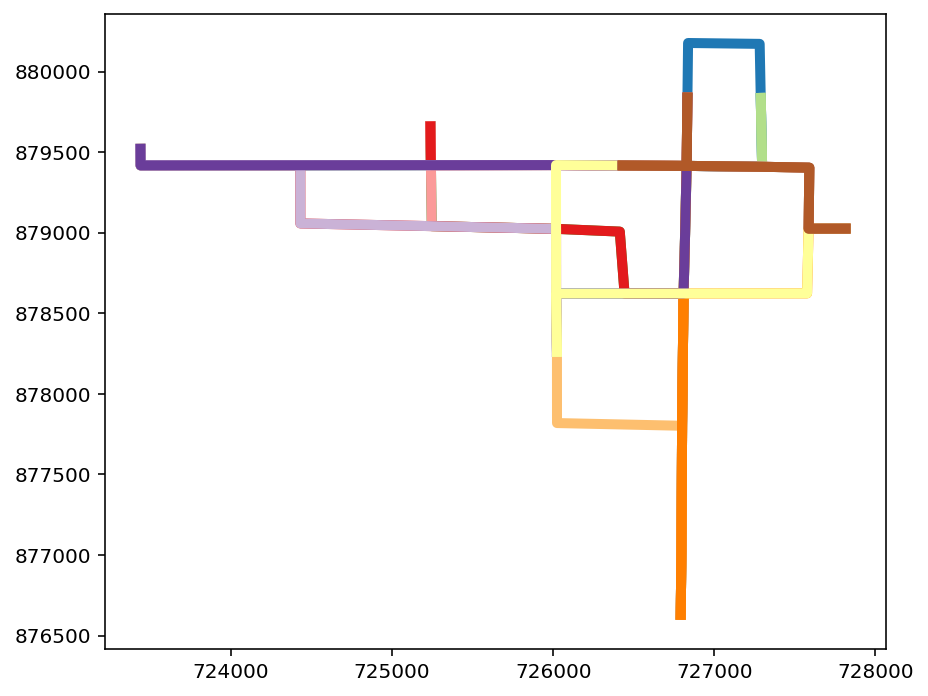

In [20]:
paths_gdf.plot(figsize=(7, 7), column=paths_gdf.index.name, cmap="Paired", linewidth=5);

#### 2.6. Plot the routes within the context of the network

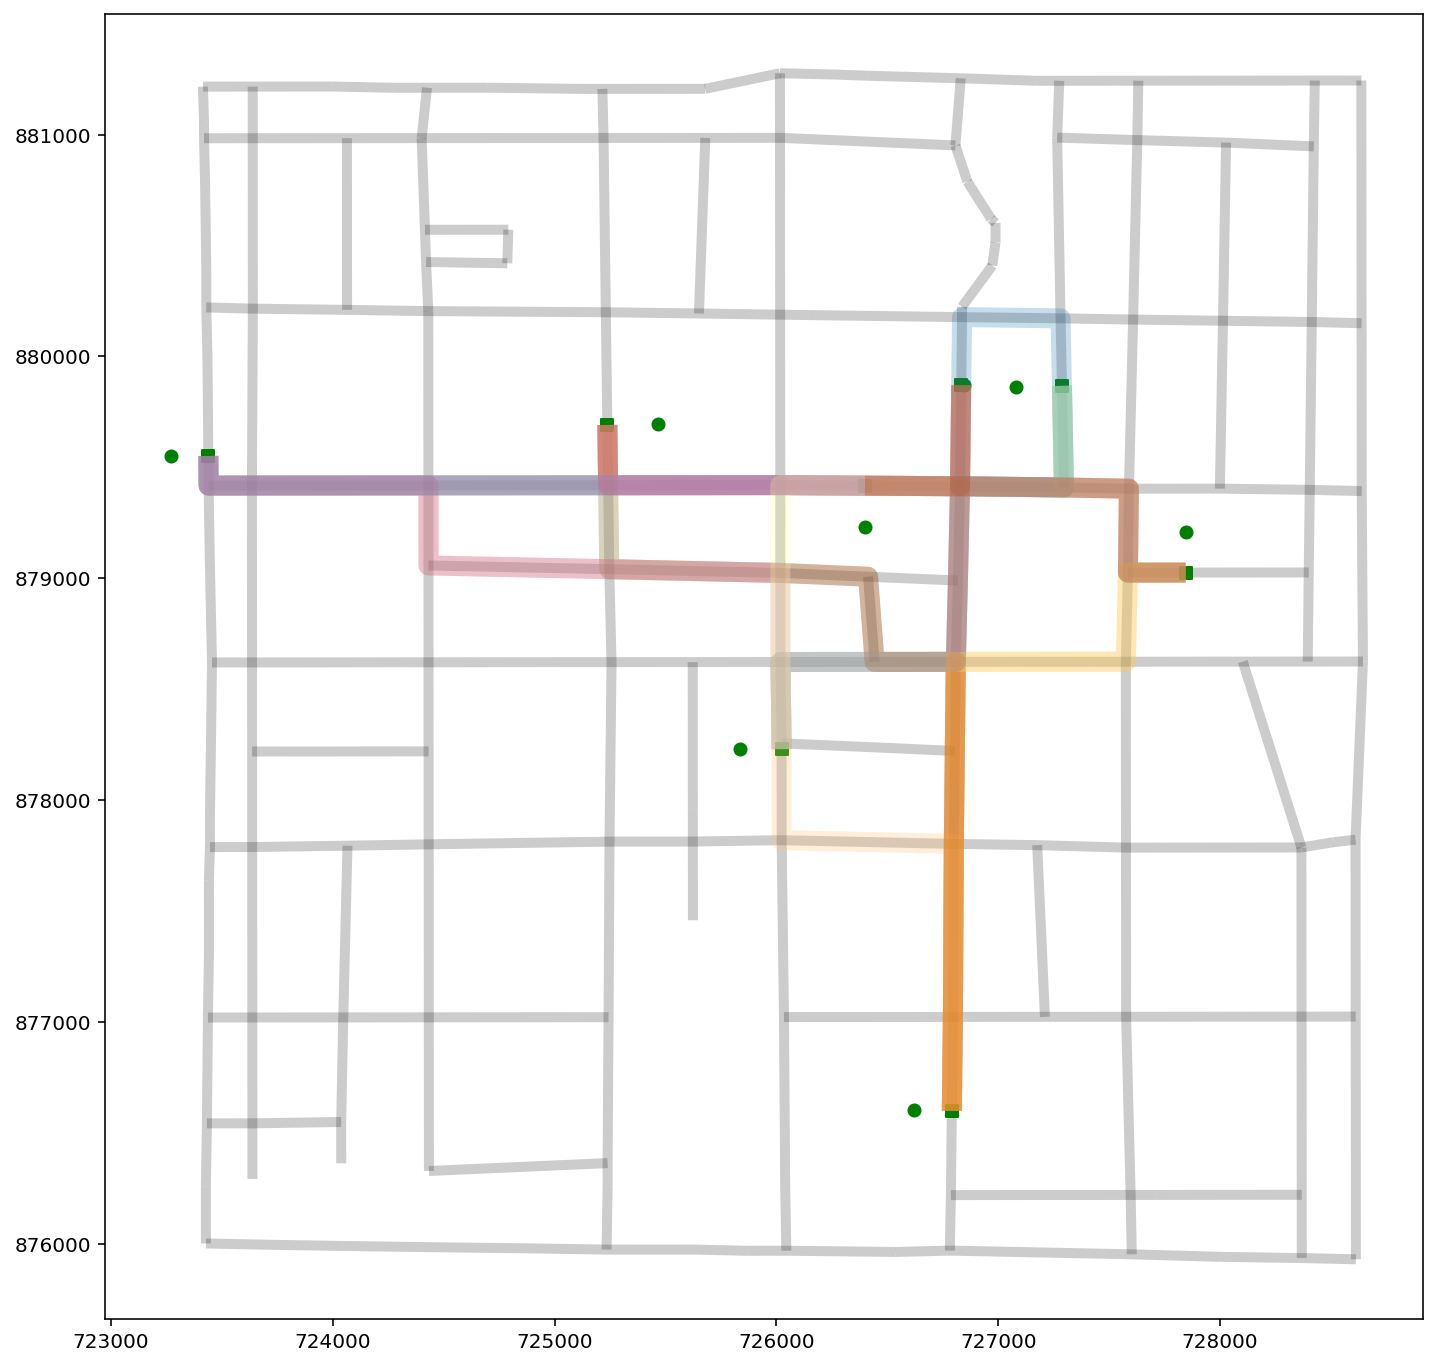

In [21]:
base = arcs.plot(alpha=0.2, linewidth=5, color="k", figsize=(12, 12), zorder=0)
pp_obs.plot(ax=base, color="g", zorder=2)
pp_obs_snapped.plot(ax=base, color="g", marker="s", zorder=2)
paths_gdf.plot(ax=base, column="id", cmap="Paired", linewidth=10, alpha=0.25);

-----------------------